In [2]:
using Pkg
Pkg.activate("..")

using Distributions, LinearAlgebra, MiCRM, EasyFit, Distances, StatsBase, Random
using OrdinaryDiffEq, DiffEqCallbacks
using CairoMakie, Colors, ColorSchemes
using JLD2
using Optim, ForwardDiff

  Activating project at `~/Projects/Working/ErCite/chemicalstressors`


In [3]:
Pkg.status()

Status `~/Projects/Working/ErCite/chemicalstressors/Project.toml`
  [13f3f980] CairoMakie v0.10.0
  [35d6a980] ColorSchemes v3.20.0
  [5ae59095] Colors v0.12.8
  [459566f4] DiffEqCallbacks v2.24.3
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.79
  [fde71243] EasyFit v0.5.7
  [f6369f11] ForwardDiff v0.10.32
  [033835bb] JLD2 v0.4.29
  [20f20a25] MakieCore v0.6.0
  [a39c0ef7] MiCRM v0.0.2 `https://github.com/CleggTom/MiCRM.jl.git#main`
  [429524aa] Optim v1.7.4
  [1dea7af3] OrdinaryDiffEq v6.35.1
  [2913bbd2] StatsBase v0.33.21
  [0c5d862f] Symbolics v4.13.0


# Introduction

In [220]:
#Dirchlet U matricies
function dirchlet_uptake(N,M,kw)
    Array(rand(Dirichlet(M, kw[:a]), N)')
end

function f_ρ(N,M,kw)
    ρ = zeros(M)
    ρ[1] = kw[:ρ]
    
    # ρ = fill(kw[:ρ], M)
    return(ρ)
end

f_ω(N,M,kw) = fill(0.0, M)

dx!(dx,x,p,t) = MiCRM.Simulations.dx!(dx,x,p,t)

#extinction callback
function condition(u,t,integrator)
    any(u[1:integrator.p.N] .< eps())
end

function affect!(integrator)
    for i = 1:integrator.p.N
        if integrator[i] < eps()
            integrator.u[i] = 0.0
        end
    end
end
#combine with steady state
ext_cb = DiscreteCallback(condition,affect!)
steady = TerminateSteadyState(1e-3, 1e-6)
positive = PositiveDomain()

cb = CallbackSet(steady)

Random.seed!(1)
N,M = 20,20
p = MiCRM.Parameters.generate_params(N, M,f_u = dirchlet_uptake, f_ρ = f_ρ, f_ω = f_ω, a = 1.0, λ = 0.1, ρ = M)
prob = ODEProblem(dx!, ones(N+M),(0.0,1e10),p)
solve(prob, AutoTsit5(Rosenbrock32()), callback = cb);
@time sol = solve(prob, AutoTsit5(Rosenbrock32()), callback = cb);

print(sol.retcode, "  ", sol.t[end])

  0.025382 seconds (635 allocations: 241.656 KiB)
Terminated  127.70961379656535

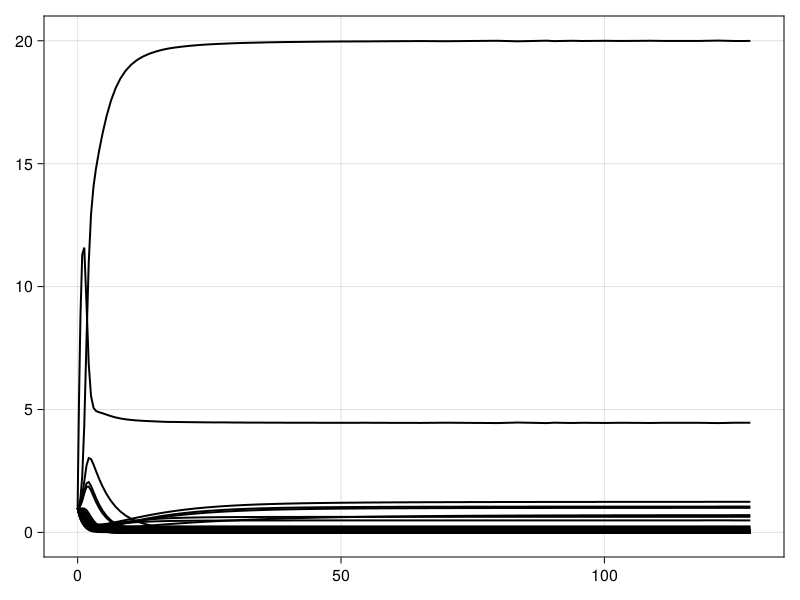

In [221]:
series(sol.t, sol[:,:], solid_color = "black")

In [223]:
#removal
function remove_random(sol)
    sol_original = deepcopy(sol)
    #get starting state
    x0_new = sol_original[end]
    extant = findall(x0_new[1:N] .> eps())
    to_remove = sample(extant)

    #remove and resimulate
    x0_new[to_remove] = 0.0
    p_new = sol_original.prob.p
    
    p_new.u[to_remove,:] .= 0.0
    p_new.m[to_remove] = 0.0
    
    prob_new = ODEProblem(dx!, x0_new,(0.0,1e6),p_new)
    sol_new = solve(prob_new, AutoTsit5(Rosenbrock32()), callback = cb);
    return(sol_new)
end

function get_N(sol)
    sum(sol[end][1:sol.prob.p.N] .> eps()) 
end

get_N (generic function with 1 method)

In [231]:
get_N(sol)

3

In [227]:
function random_extinctions(s)
    N_vec = Int[]
    Random.seed!(s)
    N,M = 20,25
    p = MiCRM.Parameters.generate_params(N, M,f_u = dirchlet_uptake, f_ρ = f_ρ, f_ω = f_ω, a = 0.1, λ = 0.3, ρ = M)
    prob = ODEProblem(dx!, ones(N+M),(0.0,1e4),p)
    sol = solve(prob, AutoTsit5(Rosenbrock32()), callback = cb, save_everystep = false)

    while get_N(sol) > 0
        append!(N_vec, get_N(sol))
        sol = remove_random(sol)
    end
    
    return(N_vec)
end

random_extinctions (generic function with 1 method)

In [228]:
random_extinctions(1)

LoadError: InterruptException:

In [126]:
dgdR(p, R, i, a) = p.u[i,a] * (1 - p.kw.λ)

function dLdC(p, R, j, a)
    v = 0.0
    for b = 1:p.M
        v += p.l[b,a] * R[b] * p.u[j,b]
    end
    return v
end

dUdC(p, R, j, a) = R[a] * p.u[j,a]

function a_L(p,R,i,j)
    v = 0.0
    for a = 1:p.M
        v += dgdR(p,R,i,a) * dLdC(p,R,j,a)
    end
    return(v)
end

function a_U(p,R,i,j)
    v = 0.0
    for a = 1:p.M
        v += dgdR(p,R,i,a) * dUdC(p,R,j,a)
    end
    return(v)
end

get_U_mat(p,R) = [a_U(p,R,i,j) for i = 1:p.N , j = 1:p.N]
get_L_mat(p,R) = [a_L(p,R,i,j) for i = 1:p.N , j = 1:p.N]

get_L_mat (generic function with 1 method)